# **Introduction to LangGraph**

## **What's Covered?**
1. What is LangGraph?
2. Why is LangGraph powerful?
3. Key Components of LangGraph
    - State and Reducer
    - Defining a Graph (Nodes and Edges)
    - Compiling a StateGraph
5. Visualizing the Graph
6. Graph with Multiple Inputs
7. Summary

## **What is LangGraph?**
**LangGraph** is an open-source framework built on top of **LangChain**, designed to help you build **stateful, multi-step LLM applications as graphs**.

It’s inspired by traditional computation graphs (like in Airflow or Ray) but optimized for LLM-first applications — think of workflows where the flow of execution is dynamic and dependent on LLM outputs, state, or external API responses.

In short:
> **LangGraph = LangChain + State Machine + Flow Control for LLM apps.**

Where LangChain focuses on creating modular chains (linear flows), LangGraph enables you to **Model applications as state machines or directed graphs**, where:
- Nodes can represent a sub-task like LLM calls, tool calls, or logic.
- Edges represent flow of execution i.e. transitions between nodes based on outcomes, conditions, or data.

LangGraph is ideal for:
1. Conversational agents with memory
2. Complex workflows involving decision trees
3. Multi-agent systems (e.g., agents that collaborate, debate, or vote)
4. Retry logic, conditional steps, and loops

In summary:
- LangGraph gives you fine-grained control over how your application progresses through each step, much like designing a **flowchart—but for LLMs and tools**.
- LangGraph also enables advanced features like loops, conditional branching, parallelism, resumability and statefulness - making it a goto choice for agentic production ready AI applications.
- It helps you model your workflows as a graph of nodes (tasks) and edges (routing) instead of a linear chain.

## **Why is LangGraph powerful?**

| Feature                     | Benefit                                                              |
| --------------------------- | -------------------------------------------------------------------- |
| **Graph-based execution**   | Go beyond linear chains—support branching, looping, and conditionals |
| **Stateful memory**         | Maintain memory or knowledge state between steps                     |
| **Multi-agent workflows**   | Simulate collaboration or reasoning between AI agents                |
| **Deterministic paths**     | Define exactly how your app flows based on output                    |
| **LangChain compatibility** | Fully compatible with LangChain tools and components                 |
| **Production-ready**        | Designed with retries, fallbacks, observability in mind              |

## **Key Components of LangGraph**
1. State and Reducer
2. Defining a Graph (Nodes and Edges)
3. Compiling a StateGraph

### **1. State and Reducer**
**State** in LangGraph is a central shared dictionary (or object) that holds context as it moves through the graph. Each node can read from, modify, or add to the state.

**Reducer** defines how updates are applied to the shared state. Note that, each "key" in the state can have its own reducer, which determines whether new data overwrites (replaces) or concatinates (merges) to the existing value.

In [1]:
from typing import TypedDict

# Define a State
class TemperatureState(TypedDict):
    celsius: float      # Input
    fahrenheit: float   # Output

### **2. Defining a Graph (Nodes and Edges)**

The Graph is the full computation DAG (Directed Acyclic Graph). It contains:
- State definition
- Nodes
- Edges

LangGraph uses StateGraph for this.

#### **Nodes**
A node is a function (or LangChain component) that:
- Accepts a state as input
- Does something with it (e.g., call LLM, DB, tool)
- Returns an updated state

You can think of it as one step in your workflow.

In [2]:
def celsius2fahrenheit_converter(state: TemperatureState) -> TemperatureState:
    # 1. READ the input
    c_temp = state["celsius"]
    
    # 2. CALCULATE
    # Formula: (C * 9/5) + 32
    f_temp = (c_temp * 1.8) + 32

    # 3. WRITE the update
    state["fahrenheit"] = round(f_temp, 2)
    
    # 3. WRITE the update
    return state

#### **Edges**

An edge connects one node to another. LangGraph supports:
- Static edges: direct transitions
- Conditional edges: choose next node based on logic or state

In [3]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TemperatureState)

# Add Nodes
graph.add_node("c2f_node", celsius2fahrenheit_converter)

# Add Edges
graph.add_edge(START, "c2f_node")
graph.add_edge("c2f_node", END)

### **3. Compiling a StateGraph**
Once nodes and edges are added, you compile the graph and run it.

This step checks the logical graph structure and prepare it for execution.

In [4]:
workflow = graph.compile()

### **4. Invoking the Graph**

In [5]:
workflow.invoke({"celsius": 5})

{'celsius': 5, 'fahrenheit': 41.0}

### **Visualizing the Graph**

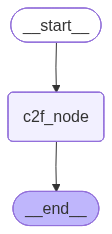

In [6]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

## **Graph with Multiple Inputs**

In [7]:
# Step 1: Defining a State
from typing import TypedDict, List

# Define a typed state
class AgentState(TypedDict):
    name: str
    values: List[int]
    response: str

In [8]:
# Step 2: Define a node

def processor_node(state: AgentState) -> AgentState:
    """This function takes a list and return the sum of all the values."""
    state['response'] = f"Hi {state['name']}, Sum of input list is {sum(state['values'])}."
    return state

In [9]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("node", processor_node)

graph.add_edge(START, "node")
graph.add_edge("node", END)

In [10]:
# Step 4: Compile the graph

app = graph.compile()

In [11]:
# Step 5: Invoke
app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9]})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'response': 'Hi ThatAIGuy, Sum of input list is 15.'}

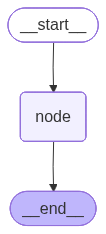

In [12]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## **Summary**

| Component       | Description                                                                                                                |
| --------------- | -------------------------------------------------------------------------------------------------------------------------- |
| `Node`       | A function or LangChain component (e.g., Chain, Tool, Agent) that performs a task. Each node receives and returns a state. |
| `Edge`       | A transition between nodes. Can be unconditional or conditional (based on output or state).                                |
| `Graph`      | A combination of nodes + edges. Represents the full workflow.                                                              |
| `State`      | A central dictionary that holds all context shared across nodes. Think of it like a memory store or a context object.      |
| `StateGraph` | A special LangGraph class that helps you define, validate, and execute your graph logic with type-safe states.             |